In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import xgboost as xgb

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [5]:
TRAIN_DATASET_PATH = 'C:/Users/1/Downloads/reppm/train.csv'
TEST_DATASET_PATH = 'C:/Users/1/Downloads/reppm/test.csv'

# Описание датасета

Id - идентификационный номер квартиры DistrictId - идентификационный номер района Rooms - количество комнат Square - площадь LifeSquare - жилая площадь KitchenSquare - площадь кухни Floor - этаж HouseFloor - количество этажей в доме HouseYear - год постройки дома Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности Social_1, Social_2, Social_3 - социальные показатели местности Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров Price - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train_df.sample(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1615,1488,58,2.0,41.583313,26.952661,5.0,6,14.0,1971,0.148904,B,B,9,1952,1,1430.0,3,2,B,154843.897204
534,4056,6,2.0,54.843547,34.179228,9.0,12,17.0,2010,0.243205,B,B,5,1564,0,540.0,0,0,B,192023.078039
6367,10196,30,3.0,80.372960,78.637580,1.0,8,25.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,175738.125270
1859,11819,75,3.0,55.451900,37.010022,5.0,4,5.0,1963,0.122090,B,B,29,6566,7,1894.0,4,0,B,204562.762958
6438,1546,23,3.0,79.889159,NaN,1.0,13,25.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,193928.411018


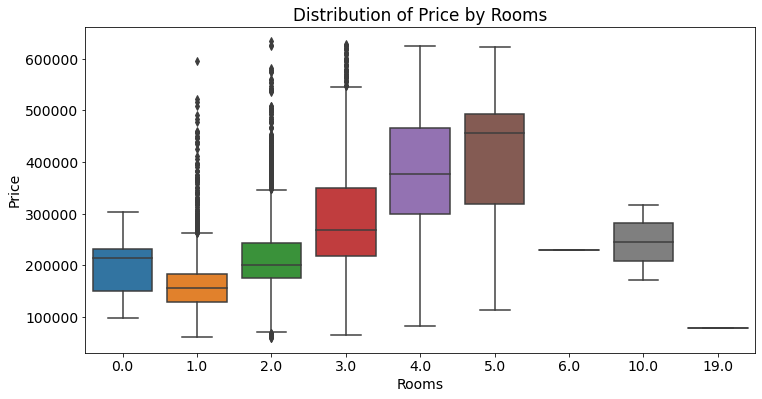

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(train_df['Rooms'], train_df['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show()

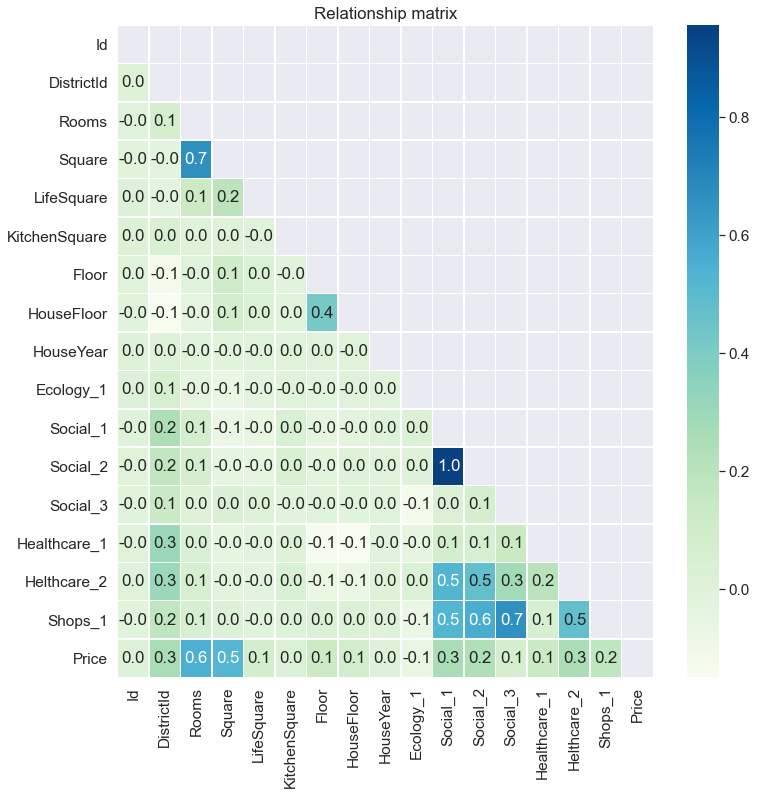

In [9]:
corr = train_df.corr()
plt.figure(figsize = (12, 12))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(train_df.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Relationship matrix')
plt.show()

# EDA

In [10]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [11]:
train_df.drop('Id', axis=1, inplace=True)

In [12]:
test_df.drop('Id', axis=1, inplace=True)

In [13]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [14]:
test_df.drop('Healthcare_1', axis=1, inplace=True)

In [15]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [16]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.65 MB
Memory usage after optimization is: 0.19 MB
Decreased by 71.3%


In [17]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.37 MB
Memory usage after optimization is: 0.43 MB
Decreased by 68.7%


In [18]:
train_df.dtypes

DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

Обработка выбросов

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
train_df.loc[(train_df['Rooms'] < 1), 'Rooms'] = 1

In [21]:
test_df.loc[(test_df['Rooms'] < 1), 'Rooms'] = 1

In [22]:
train_df.loc[(train_df['Rooms'] > 6), 'Rooms'] = train_df['Rooms'].median()

In [23]:
test_df.loc[(test_df['Rooms'] > 6), 'Rooms'] = test_df['Rooms'].median()

In [24]:
train_df.loc[(train_df['HouseYear'] > 2020), 'HouseYear'] = 2020

In [25]:
test_df.loc[(test_df['HouseYear'] > 2020), 'HouseYear'] = 2020

In [26]:
train_df.loc[(train_df['Square'] > 300) & (train_df['Rooms'] < 4), 'Square'] = train_df['Square'].median()

In [27]:
test_df.loc[(test_df['Square'] > 300) & (test_df['Rooms'] < 4), 'Square'] = test_df['Square'].median()

In [28]:
train_df.loc[(train_df['Square'] < 10) & (train_df['LifeSquare'] < 10), 'Square'] = train_df['Square'].median()

In [29]:
test_df.loc[(test_df['Square'] < 10) & (test_df['LifeSquare'] < 10), 'Square'] = test_df['Square'].median()

In [30]:
test_df['lsq_ratio'] = test_df['LifeSquare'] / test_df['Square']

In [31]:
train_df['lsq_ratio'] = train_df['LifeSquare'] / train_df['Square']

In [32]:
lsq = train_df.loc[(train_df['lsq_ratio'] < 1) | (train_df['lsq_ratio'] > 0.1), 'lsq_ratio'].median()

In [33]:
lsq

0.6173835396766663

In [34]:
train_df['LifeSquare'].fillna((train_df['Square']) * lsq, inplace=True)

In [35]:
test_df['LifeSquare'].fillna((test_df['Square']) * lsq, inplace=True)

In [36]:
train_df.loc[(train_df['LifeSquare'] > 200)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,lsq_ratio
357,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,0,2,B,141780.234375,5.439478
1776,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,1,4,B,528560.500000,1.006453
1906,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,3,7,B,455264.875000,0.848733
5183,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,1,7,B,394253.312500,5.911703
7010,102,1.0,52.513309,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,3,6,B,90470.429688,7.819727
7644,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,0,1,B,302211.250000,0.992010
8000,27,3.0,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,B,B,2,469,0,0,0,B,217357.500000,91.567970
9229,30,2.0,52.513309,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,3,23,B,133529.687500,12.152409


In [37]:
train_df.loc[(train_df['LifeSquare'] > 300) & (train_df['Rooms'] < 4), 'LifeSquare'] = train_df['LifeSquare'].median()

In [38]:
test_df.loc[(test_df['LifeSquare'] > 300) & (test_df['Rooms'] < 4), 'LifeSquare'] = test_df['LifeSquare'].median()

In [39]:
train_df.loc[train_df['Square'] < 15]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,lsq_ratio
7033,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,3,9,B,412511.093750,12.302704
8805,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,0,1,B,97560.718750,9.314857
9067,1,3.0,4.823679,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,0,1,B,237716.687500,16.536747
9286,81,3.0,13.784864,15.988890,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,5,8,B,78388.804688,1.159887


In [40]:
train_df.loc[(train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare']), 'Square'] = train_df['LifeSquare'] / lsq

In [41]:
test_df.loc[(test_df['Square'] < 10) & (test_df['Square'] < test_df['LifeSquare']), 'Square'] = test_df['LifeSquare'] / lsq

In [42]:
train_df.loc[train_df['LifeSquare'] < 10]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,lsq_ratio
26,88,3.0,83.262527,4.769175,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,3,9,B,410883.906250,0.057279
119,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,174742.000000,0.012510
161,45,1.0,52.513039,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,3,2,B,438005.187500,0.100114
212,27,1.0,38.936985,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,0,1,B,93560.789062,0.078699
227,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,0,0,A,133721.125000,0.041617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,59,1.0,48.232742,3.288779,1.0,15,17.0,2017,0.019509,B,B,37,7687,11,5,5,B,207086.640625,0.068186
9869,27,1.0,52.513039,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.945312,0.016627
9912,23,1.0,52.787090,5.600609,1.0,7,1.0,2015,0.014073,B,B,2,475,0,0,0,B,104160.492188,0.106098
9938,34,4.0,94.888596,2.637095,1.0,4,1.0,2018,0.069753,B,B,53,13670,4,1,11,B,346949.500000,0.027791


In [43]:
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Square'] > 20)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,lsq_ratio
26,88,3.0,83.262527,4.769175,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,3,9,B,410883.906250,0.057279
119,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,174742.000000,0.012510
161,45,1.0,52.513039,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,3,2,B,438005.187500,0.100114
212,27,1.0,38.936985,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,0,1,B,93560.789062,0.078699
227,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,0,0,A,133721.125000,0.041617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,59,1.0,48.232742,3.288779,1.0,15,17.0,2017,0.019509,B,B,37,7687,11,5,5,B,207086.640625,0.068186
9869,27,1.0,52.513039,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.945312,0.016627
9912,23,1.0,52.787090,5.600609,1.0,7,1.0,2015,0.014073,B,B,2,475,0,0,0,B,104160.492188,0.106098
9938,34,4.0,94.888596,2.637095,1.0,4,1.0,2018,0.069753,B,B,53,13670,4,1,11,B,346949.500000,0.027791


In [44]:
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Square'] > 20), 'LifeSquare'] = train_df['Square'] * lsq

In [45]:
test_df.loc[(test_df['LifeSquare'] < 10) & (test_df['Square'] > 20), 'LifeSquare'] = test_df['Square'] * lsq

In [46]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [47]:
train_df['Kit_sq_ratio'] = train_df['KitchenSquare'] / train_df['Square']

In [48]:
test_df['Kit_sq_ratio'] = test_df['KitchenSquare'] / test_df['Square']

In [49]:
ksq = train_df.loc[(train_df['KitchenSquare'] > 2) & (train_df['KitchenSquare'] < 100), 'Kit_sq_ratio'].median()

In [50]:
ksq

0.14814800024032593

In [51]:
train_df.loc[(train_df['KitchenSquare'] < 2) | (train_df['KitchenSquare'] > 100 | (train_df['KitchenSquare'] > train_df['Square'])), 'KitchenSquare']= train_df['Square'] * ksq

In [52]:
test_df.loc[(test_df['KitchenSquare'] < 2) | (test_df['KitchenSquare'] > 100 | (test_df['KitchenSquare'] > test_df['Square'])), 'KitchenSquare']= test_df['Square'] * ksq

In [53]:
def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1930, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1930) & (X['HouseYear'] <= 1958), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1958) & (X['HouseYear'] <= 1985), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1985) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2018), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2018), 'year_cat'] = 6
            
        return X

1 - Старый фонд 2 - Сталинки 3 - Хрущевки 6 - Новостройки

In [54]:
train_df = year_to_cat(train_df)

In [55]:
test_df = year_to_cat(test_df)

Добавим признак газификации дома (дома с этажностью до 9)

In [56]:
def gasification(X):

    X['Gas'] = 0
    X.loc[(X['HouseFloor'] <= 9), 'Gas'] = 1  

    return X

In [57]:
train_df = gasification(train_df)

In [58]:
test_df = gasification(test_df)

Добавим признак 'дом под снос' (пятиэтажки, построенные с 1957 по 1968)

In [59]:
def renovation(X):

    X['Snos'] = 0
    X.loc[(X['HouseFloor'] == 5) & (X['HouseYear'] > 1956) & (X['HouseYear'] < 1969), 'Snos'] = 1  

    return X

In [60]:
train_df = renovation(train_df)

In [61]:
test_df = renovation(test_df)

Самое высокое здание в Москве с этажностью 95, все что выше нужно заменить

In [62]:
train_df.loc[(train_df['HouseFloor'] > 95), 'HouseFloor'] = train_df['HouseFloor'].median() 

In [63]:
test_df.loc[(test_df['HouseFloor'] > 95), 'HouseFloor'] = test_df['HouseFloor'].median() 

In [64]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [65]:
train_df.loc[train_df['HouseFloor'] < 1, 'HouseFloor'].value_counts()

0.0    269
Name: HouseFloor, dtype: int64

In [66]:
train_df.loc[(train_df['HouseFloor'] < 1), 'HouseFloor'] = train_df['Floor'] 

In [67]:
test_df.loc[(test_df['HouseFloor'] < 1), 'HouseFloor'] = test_df['Floor'] 

In [68]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].median()

In [69]:
test_df.loc[(test_df['Floor'] > test_df['HouseFloor']), 'HouseFloor'] = test_df['HouseFloor'].median()

In [70]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [71]:
test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [72]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [73]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

In [74]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')

In [75]:
test_df['DistrictSize'].fillna(test_df['DistrictSize'].median(), inplace=True)

In [76]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

In [77]:
train_df = floor_to_cat_pandas(train_df)

In [78]:
test_df = floor_to_cat_pandas(test_df)

In [79]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1.0,0,321319.46875
1,1.0,1,324303.81250
2,1.0,2,355767.59375
3,2.0,0,308257.06250
4,2.0,1,302975.21875


In [80]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,lsq_ratio,Kit_sq_ratio,year_cat,Gas,Snos,DistrictSize,floor_cat,MedPriceByFloorYear
0,27,3.0,115.027313,71.015968,17.041067,4,10.0,2014,0.075424,1,...,1,305018.875000,NaN,0.086936,5.0,0,0,851,1,182881.093750
1,22,1.0,39.832523,23.169222,5.901109,7,8.0,1966,0.118537,1,...,1,177734.546875,0.581666,0.200841,3.0,1,0,78,2,188722.843750
2,1,3.0,78.342216,47.671970,11.606243,2,17.0,1988,0.025609,1,...,1,282078.718750,0.608509,0.127645,4.0,0,0,652,0,205708.062500
3,1,1.0,40.409908,24.948412,5.986647,10,22.0,1977,0.007122,1,...,1,168106.000000,NaN,0.024746,3.0,0,0,652,3,189407.421875
4,94,2.0,64.285065,38.562515,9.523704,16,16.0,1972,0.282798,1,...,1,343995.093750,0.599867,0.140001,3.0,0,0,89,4,185193.843750


In [81]:
test_df = test_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')

In [82]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'lsq_ratio',
 'Kit_sq_ratio',
 'year_cat',
 'Gas',
 'Snos',
 'DistrictSize',
 'floor_cat',
 'MedPriceByFloorYear']

In [83]:
train_df.drop('lsq_ratio', axis=1, inplace=True)

In [84]:
test_df.drop('lsq_ratio', axis=1, inplace=True)

In [85]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

In [86]:
new_feature_names = ['lsq_ratio', 'Kit_sq_ratio','year_cat', 'Gas', 'Snos', 'DistrictSize', 'floor_cat', 'MedPriceByFloorYear']

In [87]:
features_to_drop = ['Kit_sq_ratio', 'Ecology_2', 'Ecology_3', 'Shops_2', 'year_cat', 'KitchenSquare', 'floor_cat']

In [88]:
train_df = train_df.drop(columns=features_to_drop)

In [89]:
test_df = test_df.drop(columns=features_to_drop)

In [90]:
target_name = 'Price'

In [91]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [93]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 17), (3300, 17), (5000, 17))

In [94]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [95]:
test_df.isna().sum()

DistrictId             0
Rooms                  0
Square                 0
LifeSquare             0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Social_1               0
Social_2               0
Social_3               0
Helthcare_2            0
Shops_1                0
Gas                    0
Snos                   0
DistrictSize           0
MedPriceByFloorYear    0
dtype: int64

parameters = [{
'colsample_bytree': np.arange(0.1, 0.5),
}]

rge = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=3,
)

    %%time
rge.fit(X_train, y_train)

rge.best_params_

xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.01, subsample=0.5)
xgb_model.fit(X_train, y_train)

In [97]:
from sklearn.ensemble import GradientBoostingRegressor

In [98]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

In [100]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

Train R2:	0.856
Test R2:	0.763


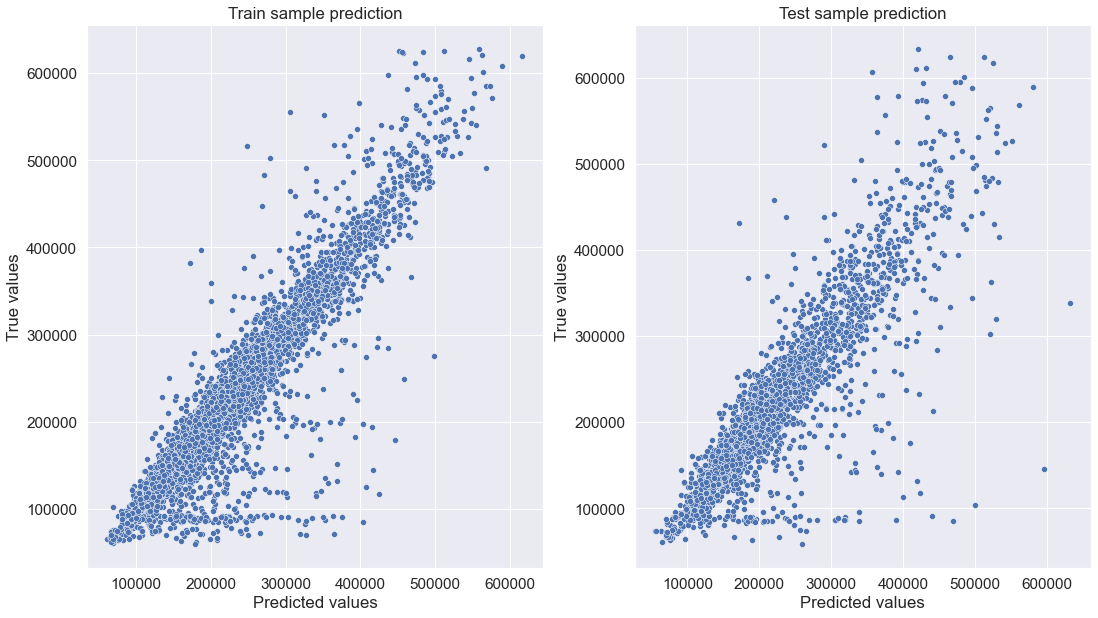

In [101]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [103]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.76689667, 0.73562745, 0.74046561, 0.73943529, 0.74739044])

In [104]:
cv_score.mean()

0.7459630917513228

In [105]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.232597
1,Rooms,0.152056
15,DistrictSize,0.134739
3,LifeSquare,0.113689
9,Social_2,0.070327
8,Social_1,0.055700
10,Social_3,0.047325
0,DistrictId,0.041662
7,Ecology_1,0.036298
6,HouseYear,0.030531


In [106]:
test_df.shape

(5000, 17)

In [107]:
submit = pd.read_csv('C:/Users/1/Downloads/reppm/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [108]:
predictions = gb_model.predict(test_df)
predictions

array([175633.52436504, 122891.79059052, 136777.18275336, ...,
       152900.24338274, 188802.06298963, 285650.88037355])

In [109]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,175633.524365
1,5925,122891.790591
2,960,136777.182753
3,3848,104424.375945
4,746,200956.468876


In [110]:
submit.to_csv('C:/Users/1/Downloads/reppm/rf_submit.csv', index=False)